# Example: Lattice Model of Interest Rates
Fill me in

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-3/L3a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-3/L3a/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-3/L3a`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-3/L3a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-3/L3a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-3/L3a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2

## Prerequisite: Load the Treasury Rates Dataset
In this section, we'll load the data we will use below and set up some other stuff required for the subsequent calculations. The interest rate data is available from the [United States Treasury](https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics) in a [`CSV` flat-file format](https://en.wikipedia.org/wiki/Comma-separated_values). We've already downloaded several years' worth of data and saved it in the `<root>/data` directory. To load the data, we use [the `read(...)` exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) and save the data in the `tbill_rates_dataset::DataFrame` variable.
* What is going on in the [`read(...)` method call](https://csv.juliadata.org/stable/reading.html#CSV.read)? This method requires a path to the data file, specified [using the Julia `joinpath(...)` method](https://docs.julialang.org/en/v1/base/file/#Base.Filesystem.joinpath), and a type to load the data into, specified as a [`DataFrame` type exported by the DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl). We use [the Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) in combination with the [Julia `reverse(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.reverse-Tuple{AbstractVector}) to put the Treasury Bill data into date-ascending order.

In [5]:
tbill_rates_dataset = CSV.read(joinpath(_PATH_TO_DATA, "UST-Daily-TBill-Rates-2024.csv"), DataFrame) |> reverse

Row,Date,4 WEEKS BANK DISCOUNT,4 WEEKS COUPON EQUIVALENT,8 WEEKS BANK DISCOUNT,8 WEEKS COUPON EQUIVALENT,13 WEEKS BANK DISCOUNT,13 WEEKS COUPON EQUIVALENT,17 WEEKS BANK DISCOUNT,17 WEEKS COUPON EQUIVALENT,26 WEEKS BANK DISCOUNT,26 WEEKS COUPON EQUIVALENT,52 WEEKS BANK DISCOUNT,52 WEEKS COUPON EQUIVALENT
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,01/02/2024,5.28,5.39,5.28,5.41,5.22,5.38,5.21,5.39,5.04,5.26,4.57,4.81
2,01/03/2024,5.27,5.38,5.28,5.41,5.24,5.4,5.21,5.39,5.06,5.28,4.58,4.82
3,01/04/2024,5.29,5.4,5.28,5.41,5.24,5.4,5.21,5.39,5.06,5.28,4.61,4.85
4,01/05/2024,5.28,5.39,5.27,5.4,5.24,5.4,5.2,5.38,5.05,5.27,4.61,4.85
5,01/08/2024,5.28,5.39,5.28,5.41,5.25,5.41,5.19,5.37,5.04,5.26,4.59,4.83
6,01/09/2024,5.28,5.39,5.26,5.39,5.24,5.4,5.19,5.37,5.04,5.26,4.6,4.84
7,01/10/2024,5.27,5.38,5.26,5.39,5.23,5.39,5.19,5.37,5.04,5.26,4.6,4.84
8,01/11/2024,5.28,5.39,5.27,5.4,5.23,5.39,5.18,5.36,5.03,5.25,4.54,4.77
9,01/12/2024,5.28,5.39,5.27,5.4,5.22,5.37,5.17,5.35,4.98,5.19,4.45,4.67


Given that we are using daily data, the time step is `1-day` in units of trading years, i.e., a year consisting of approximately 252 trading days. Alternatively, we could use a calendar `365-day` year. Given the model development below, both choices will give equal results. Set the time step in the `Δt::Float64` variable.

In [7]:
Δt = (1/252); 

## Task 1: Build a Lattice Model and look at its properties
In this task, we'll build a lattice model, look at its properties, and compare our calculations with [an online example lattice](https://martin-haugh.github.io/files/FoundationsFE/lattice_models.pdf) to see how we compare. First, specify values for the probability of an `up` move $p$, the `up` factor $u$, the `down` factor $d$, the number of levels `T,` and the root value `rₒ.` Then, we'll populate the tree and look at its fields (so we understand what is in the tree model, and how the data is stored).

In [65]:
# parameters were chosen to mimic Haugh term structure notes, see https://martin-haugh.github.io/teaching/foundations-fe/
p = 0.50;  # probability of an up move
u = 1.25;  # up factor
d = 0.9;   # down factor
T = 4;     # number of levels excluding root in the tree => zero-based, so this will give T + 1 levels
rₒ = 0.06; # initial value of rate at the root node

Next, we construct a [`MySymmetricBinaryInterestRateLatticeModel` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MySymmetricBinaryInterestRateLatticeModel), which holds the data for the lattice model, using [a custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MySymmetricBinaryInterestRateLatticeModel},%20NamedTuple}). The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MySymmetricBinaryInterestRateLatticeModel},%20NamedTuple}) takes two arguments and returns a partially populate tree model. 
* The first argument is the type of model that we want to build, i.e., [a `MySymmetricBinaryInterestRateLatticeModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MySymmetricBinaryInterestRateLatticeModel) while the second argument is the required data passed in [using a Julia `NamedTuple`](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple).

In [11]:
my_lattice_tree_model = build(MySymmetricBinaryInterestRateLatticeModel, (
    p = p, u = u, d = d, T = T, rₒ = rₒ
)) |> populate;

Fill me in

In [13]:
my_lattice_tree_model.data

Dict{Int64, MyBinaryInterestRateLatticeNodeModel} with 6 entries:
  0 => MyBinaryInterestRateLatticeNodeModel(1.0, 0.1, 2.12768e-314)
  4 => MyBinaryInterestRateLatticeNodeModel(0.5, 0.1, 6.84944e-314)
  5 => MyBinaryInterestRateLatticeNodeModel(0.25, 0.064, 6.84949e-314)
  2 => MyBinaryInterestRateLatticeNodeModel(0.5, 0.08, 0.0)
  3 => MyBinaryInterestRateLatticeNodeModel(0.25, 0.15625, 6.84949e-314)
  1 => MyBinaryInterestRateLatticeNodeModel(0.5, 0.125, 6.66787e-314)

Fill me in

In [15]:
my_lattice_tree_model.connectivity

Dict{Int64, Vector{Int64}} with 3 entries:
  0 => [1, 2]
  2 => [4, 5]
  1 => [3, 4]

Fill me in

In [17]:
my_lattice_tree_model.levels

Dict{Int64, Vector{Int64}} with 3 entries:
  0 => [0]
  2 => [3, 4, 5]
  1 => [1, 2]

## Task 2: Estimate the Lattice Model Parameters from Data
In this task, we'll estimate values for the $(u,d,p)$ lattice model parameters by analyzing the values in the `tbill_rates_dataset::DataFrame` dataset. However, before we can do this, we must specify which maturity Treasury Bill we will explore. Let's specify this in the `key_column_name::String` variable.

In [19]:
key_column_name = "52 WEEKS COUPON EQUIVALENT"; # you can select any col, but let's pick the 1-year T-bill

### TODO: Analysis of the Interest Growth Rate
We'll estimate values for $(u,d,p)$ lattice parameters by analyzing the reported interest rate data. Suppose the interest rates were continuously compounded such that:
$$
\begin{equation}
r_{j} = r_{i-1}\cdot\exp\left(\mu_{j,j-1}\cdot\Delta{t}\right)
\end{equation}
$$
where $r_{\star}$ denotes the rate at time index $\star$, $\mu_{j,j-1}$ denotes the annual growth rate of $r$ between time index $j-1\rightarrow{j}$, and $\Delta{t}$ denotes the time difference between time index $j - 1\rightarrow{j}$ (units: years). We can rearrange and estimate growth rate values:
$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\log\left(\frac{r_{j}}{r_{i-1}}\right)
$$
for each time interval $j - 1\rightarrow{j}$ in the data. Let's implement this logic in the code block below.
* First, we compute the number of days of data we have in the `tbill_rates_dataset::DataFrame` by accessing the data associated with the `key_column_name::String` and then using the [Julia `length(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.length-Tuple{AbstractArray}) in combination with [the `|>` pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We save this value in the `number_of_values::Int64` variable. Finally, we initialize some storage for the growth rate values in the `rates_return_array::Array{Float64,1}` array, which will have `number_of_values - 1` entries.
* Next, we iterate through the days of data, i.e., from the day `2` $\rightarrow$ `number_of_values` using a [Julia `for-loop`](https://docs.julialang.org/en/v1/base/base/#for). For each day (index `i`), we get the $r_{j-1}$ and $r_{j}$ values from the `tbill_rates_dataset::DataFrame,` then compute the growth rate value and store it in the `rates_return_array::Array{Float64,1}` array. Note: the data is in percentages, so we convert it to decimal for the growth rate calculations.

In [21]:
number_of_values = tbill_rates_dataset[:,key_column_name] |> length;
rates_return_array = Array{Float64,1}(undef, number_of_values - 1);
for i ∈ 2:number_of_values
    rᵢ = tbill_rates_dataset[i-1,key_column_name] |> x-> x/100.0;
    r₂ = tbill_rates_dataset[i,key_column_name] |> x-> x/100.0;
    rates_return_array[i-1] = (1/Δt)*log(r₂/rᵢ)
end

#### Estimate the `up` factor $u$
We estimate the `up` factor $u$ by finding the indexes of all instances of up moves in the `rates_return_array::Array{Float64,1}` array using the [Julia `findall(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.findall-Tuple{Function,%20Any}), where the `x -> x ≥ 0` is a [Julia Anonymous function](https://docs.julialang.org/en/v1/manual/functions/#man-anonymous-functions) that check for entries in the `rates_return_array::Array{Float64,1}` array that are non-negative. We save the index vector corresponding to non-negative values in the `i` variable.
* To estimate the `up` factor $u$, we pass the index vector `i` to the `rates_return_array::Array{Float64,1}` array, which selects the non-negative values, we then compute the mean, and finally compute the `up` factor $u$. We save this value in the `u::Float64` variable.

In [23]:
i = findall(x -> x ≥ 0, rates_return_array);
u = rates_return_array[i] |> mean |> μ̄ -> exp(μ̄*Δt); # mean increase per day
println("Estimated mean up factor u = $(u)")

Estimated mean up factor u = 1.0050176146667238


#### Estimate the `down` factor $d$
We estimate the `down` factor $d$ by finding the indexes of all instances of down moves in the `rates_return_array::Array{Float64,1}` array using the [Julia `findall(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.findall-Tuple{Function,%20Any}), where the `x -> x < 0` is a [Julia Anonymous function](https://docs.julialang.org/en/v1/manual/functions/#man-anonymous-functions) that checks for entries in the `rates_return_array::Array{Float64,1}` array that are negative. We save the index vector corresponding to non-negative values in the `j` variable.
* To estimate the `down` factor $d$, we pass the index vector `j` to the `rates_return_array::Array{Float64,1}` array, which selects the negative values; we then compute the mean and finally compute the `down` factor $d$. We save this value in the `d::Float64` variable.

In [25]:
j = findall(x-> x < 0, rates_return_array);
d = rates_return_array[j] |> mean |> μ̄ -> exp(μ̄*Δt); # average decrease per day
println("Estimated mean down factor d = $(d)")

Estimated mean down factor d = 0.9928699688391478


#### Estimate the probability of an `up` move $p$
Finally, we can estimate the probability of observing an `up` move by dividing the number of up moves that we observed, computed by calculating the length of the `i` index vector using the [Julia `length(...)` method](https://docs.julialang.org/en/v1/base/arrays/#Base.length-Tuple{AbstractArray}), and dividing it by the total number of occurrences, i.e., `number_of_values - 1`. We save the probability $p$ in the `p::Float64` variable.

In [27]:
p = length(i)/(number_of_values - 1); # count the number of moves/all moves
println("Estimated probability of up move p = $(p)")

Estimated probability of up move p = 0.5490196078431373


### Check: Are the `up` and `down` moves symmetrical?
Later on (when dealing with another type of lattice model), we make the assumption that the up and down moves are symmetrical, i.e., $u = d^{-1}$. Is this relationship observed in the data? Toward this question, let's compute the percentage error $\epsilon$ between $\hat{u} \equiv d^{-1}$ and $u$:
$$
\begin{equation}
\epsilon = 100\cdot\left|\frac{(\hat{u} - u)}{u}\right|
\end{equation}
$$
and see how close the values are. Using the default setup in this example, we have a $\epsilon<1\%$ value. Thus, while not entirely true, the assumption of symmetry is a pretty good approximation of reality.

In [29]:
let
    û = 1/d;
    ϵ = abs(((u - û)/u))*100;
    println("û = $(û), u = $(u) and ϵ = $(ϵ)%")
end

û = 1.0071812335800514, u = 1.0050176146667238 and ϵ = 0.21528169076370832%


### TODO: Simulate the short and forward rates
Fill me in

In [31]:
startindex = 1;
T = 63; # zero based, we will have T + 1 levels
rₒ = tbill_rates_dataset[startindex, key_column_name]*(1/100); # value corresponding to startindex 

Update the tree model fields and repopulate the tree with new data

In [33]:
my_lattice_tree_model.p = p;
my_lattice_tree_model.u = u;
my_lattice_tree_model.d = d;
my_lattice_tree_model.T = T;
my_lattice_tree_model.rₒ = rₒ;
my_lattice_tree_model = my_lattice_tree_model |> populate;

In [34]:
lattice_rate_expectation = expectation(my_lattice_tree_model);
lattice_rate_variance = variance(my_lattice_tree_model);

#### Visualize lattice simulations
`Unhide` the code block below to see how we plotted the expected spot rate (blue line), the uncertainty cone (light blue region), and the observed spot rate (red line) for the `key_column_name` T-bill data. We used values for the $(u,d,p)$ lattice parameters estimated from data.
* __Summary__: The expected value of the spot rate, calculated using the lattice, closely matches the observed spot rate for around 20 days (given the default `startindex` value). However, after this period, the observed spot rate exceeds the simulated expected value.
* So what?: Since the lattice parameters are derived from data, we can consider the expected spot rate as a fundamental estimate. Therefore, if the observed spot rate is higher than the simulated expected spot rate, we may interpret this as a signal to __buy__, especially if we believe that the spot rate tends to revert to its mean. 

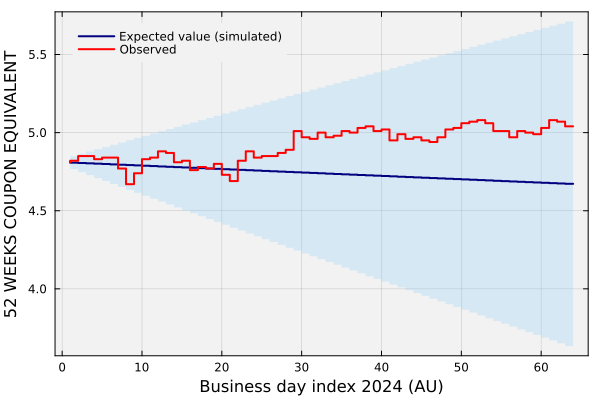

In [36]:
let
    
    # build data array -
    data_array_for_plot = Array{Float64,2}(undef, T+1,5);
    for i ∈ 0:T
        data_array_for_plot[i+1,1] = startindex + i;
        data_array_for_plot[i+1,2] = lattice_rate_expectation[i]*100;
        data_array_for_plot[i+1,3] = (lattice_rate_expectation[i] + (lattice_rate_variance[i] |> sqrt))*100
        data_array_for_plot[i+1,4] = (lattice_rate_expectation[i] - (lattice_rate_variance[i] |> sqrt))*100
        data_array_for_plot[i+1,5] = tbill_rates_dataset[startindex+i, key_column_name];
    end
    
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, legend=:topleft);
    plot!(data_array_for_plot[:,1], data_array_for_plot[:,2], linetype=:steppre, fillrange=data_array_for_plot[:,3], c=:lightskyblue, label="", alpha=0.250)
    plot!(data_array_for_plot[:,1], data_array_for_plot[:,2], linetype=:steppre, fillrange=data_array_for_plot[:,4], c=:lightskyblue, label="", alpha=0.250)
    plot!(data_array_for_plot[:,1], data_array_for_plot[:,2], linetype=:steppre, c=:navy, lw=2, label="Expected value (simulated)")
    plot!(data_array_for_plot[:,1], data_array_for_plot[:,5], c=:red, linetype=:steppre, lw=2, label="Observed")
    xlabel!("Business day index 2024 (AU)", fontsize=18)
    ylabel!("$(key_column_name)", fontsize=18)
end

## Task 3: Zero Price Simulation
Fill me in

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.